Reference:
https://techblog.insightedge.jp/entry/pinns-mass-spring-damper#Physics-informed-neural-networks-%E3%81%A8%E3%81%AF

減衰振動:
 <h2>$ m\frac{d^2x}{dt^2}+c\frac{dx}{dt}+kx = 0 \  (1)$</h2> 
 
 初期条件:
 <h2>$x(0)=1, \frac{dx}{dt} = 0 $\
 $\eta < \omega_0,  \eta =\frac{c}{2m},  \omega_0 = \sqrt{\frac{k}{m}}$</h2>
 
 解析解:
 <h2>$x(t) = e^{-\eta t}(2Acos(\varphi+\omega t)), \omega = \sqrt{\omega^2_0 - \eta^2}\  (2)$</h2> 
 
 $ k=m \times \omega_{0}^2, m=1, \omega_0 =20, c =4, \eta =2, A =0.5, \varphi = 0 $とする

In [1]:
# 解析解を0から1の間でプロットする
import numpy as np
import matplotlib.pyplot as plt
eta =3
phi = 0
A = 1/(2*np.cos(phi))
omega_0 = 28
k=omega_0 **2
c=4
m=1
omega = np.sqrt(omega_0**2 - eta**2)
t_analytical = np.linspace(0,1,500)
x_analytical = np.exp(-eta * t_analytical)*(2*A*np.cos(phi + omega*t_analytical))
# delta(t)が0.001, 0.005, 0.015の三種類のシミュレーション

オイラー法を用いて離散化：

<h2>$ x_{t+1} = x_t +\frac{dx}{dt}\Delta t\  (3)$</h2> 
<h2>$ v_{t+1} = v_t +\frac{dv}{dt}\Delta t\  (4)$</h2> 

まとめると:
<h2>$ \Delta t v_{t} + x_{t} = x_{t+1}\  (5)$</h2>
<h2>$v_{t+1}  = \frac{\Delta t}{m}[-k\times x_t - \frac{c}{\Delta t}x_{t+1} + \frac{c}{\Delta t}x_t\  ] +v_t(6)$</h2>

In [2]:
omega = np.sqrt(omega_0**2 - eta**2)
t_analytical = np.linspace(0,1,500)
x_analytical = np.exp(-eta * t_analytical)*(2*A*np.cos(phi + omega*t_analytical))
# delta(t)が0.001, 0.005, 0.015の三種類のシミュレーション

deltat1 = 0.0001
t1 = np.arange(0, 1, 0.0001)
x1 = [1]
v1 = [0]
for i in range(len(t1)):
    x1.append(deltat1 * v1[i] + x1[i]) 
    v1.append((deltat1/m)*(-k*x1[i] -(c/deltat1)*x1[i+1]+(c/deltat1)*x1[i]) +v1[i])
    
    
deltat2 = 0.005
t2 = np.arange(0, 1, 0.005)
x2 = [1]
v2 = [0]
for i in range(len(t2)):
    x2.append(deltat2 * v2[i] + x2[i]) 
    v2.append((deltat2/m)*(-k*x2[i] -(c/deltat2)*x2[i+1]+(c/deltat2)*x2[i]) +v2[i])
    
    
deltat3 = 0.015
t3 = np.arange(0, 1, 0.015)
x3 = [1]
v3 = [0]
for i in range(len(t3)):
    x3.append(deltat3 * v3[i] + x3[i]) 
    v3.append((deltat3/m)*(-k*x3[i] -(c/deltat3)*x3[i+1]+(c/deltat3)*x3[i]) +v3[i])    

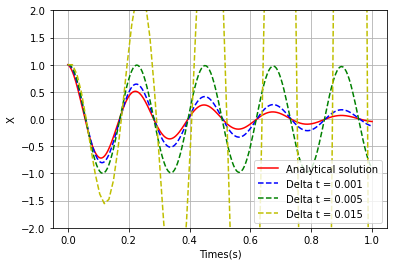

In [3]:
plt.plot(t_analytical,x_analytical,label="Analytical solution",c="r" )
plt.plot(t1,x1[:10000],label="Delta t = 0.001", linestyle='--',c="b")
plt.plot(t2,x2[:200],label="Delta t = 0.005",linestyle='--',c="g")
plt.plot(t3,x3[:67],label="Delta t = 0.015",linestyle='--',c="y")
plt.xlabel("Times(s)")
plt.ylabel("X")
plt.grid(True)
plt.ylim(-2.0, 2.0)
plt.legend()
plt.show()
#シミュレーション結果は解析解より速く収束してしまう結果になっており、ずれが大きい

In [4]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print("GPU Device:", device)

Num GPUs Available:  1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [46]:
import math
def MLP(n_input, n_output, n_neuron, n_layer, act_fn='tanh'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units=n_neuron,
            activation=act_fn,
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
            input_shape=(n_input,),
            name='H1')
    ])
    for i in range(n_layer-1):
        model.add(
            tf.keras.layers.Dense(
                units=n_neuron,
                activation=act_fn,
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                name='H{}'.format(str(i+2))
            ))
    model.add(
        tf.keras.layers.Dense(
            units=n_output,
            name='output'
        ))
    return model

class EarlyStopping:

    def __init__(self, patience=10, verbose=0):

        self.epoch = 0 
        self.pre_loss = float('inf') 
        self.patience = patience 
        self.verbose = verbose 

    def __call__(self, current_loss):

        if self.pre_loss < current_loss: 
            self.epoch += 1 

            if self.epoch > self.patience: 
                if self.verbose: 
                    print('early stopping')
                return True

        else: 
            self.epoch = 0 
            self.pre_loss = current_loss 

        return False


    
class PhysicsInformedNNs():

    def __init__(self, n_input, n_output, n_neuron, n_layer, epochs, act_fn='tanh'):
        self.model_loc = []
        self.n_input = n_input
        self.n_output = n_output
        self.n_neuron = n_neuron
        self.n_layer = n_layer
        self.epochs = epochs
        self.act_fn = act_fn

    def build(self, optimizer, loss_fn, early_stopping, batch_size,factor=0.95):
        self._model = MLP(self.n_input, self.n_output, self.n_neuron, self.n_layer, self.act_fn)
        self._optimizer = optimizer
        self.model_lr = self._optimizer.learning_rate
        print("initial learning_rate:", self.model_lr)
        self._loss_fn = loss_fn
        self._early_stopping = early_stopping
        self.batch_size = batch_size
        self.factor = factor
        return self

    def train_step(self, t_data, x_data, t_pinn, c, k, loop):
        with tf.GradientTape() as tape_total:
            tape_total.watch(self._model.trainable_variables)
            x_pred = self._model(t_data)
            loss1 = 0.2*self._loss_fn(x_pred, x_data)
            loss1 = tf.cast(loss1, dtype=tf.float32)

            with tf.GradientTape() as tape2:
                tape2.watch(t_pinn)
                with tf.GradientTape() as tape1:
                    tape1.watch(t_pinn)
                    x_pred_pinn = self._model(t_pinn)
                dx_dt = tape1.gradient(x_pred_pinn, t_pinn)
            dx_dt2 = tape2.gradient(dx_dt, t_pinn)

            dx_dt  = tf.cast(dx_dt, dtype=tf.float32)
            dx_dt2 = tf.cast(dx_dt2, dtype=tf.float32)
            x_pred_pinn = tf.cast(x_pred_pinn, dtype=tf.float32)

            loss_physics = dx_dt2 + c * dx_dt + k * x_pred_pinn
            loss2 = 5.0e-6 * self._loss_fn(loss_physics, tf.zeros_like(loss_physics))
            loss2 = tf.cast(loss2, dtype=tf.float32)
         
            loss = loss1 + loss2
            
            if loop % 300 ==0:
                
                print("loss1:", loss1.numpy(),"loss2: ",loss2.numpy(),"loss:", loss.numpy(), "train_step:",loop)

        self._optimizer.minimize(loss, self._model.trainable_variables, tape=tape_total)
        
        if loop %  self.batch_size==0 :
            self._optimizer.learning_rate.assign(self._optimizer.learning_rate * self.factor)
            print("current_learning_rate:" , self._optimizer.learning_rate)
            
        self._loss_values.append(loss)
        return self

    def train(self, t, x, t_data, x_data, t_pinn, c, k):
        self.loop = 0
        self._loss_values = []
        for i in range(self.epochs):
            self.loop += 1
            self.train_step(t_data, x_data, t_pinn, c, k, self.loop)
            if self.loop % 500 == 0:
                model_clone = tf.keras.models.clone_model(self._model)
                model_clone.set_weights(self._model.get_weights())
                self.model_loc.append(model_clone)
            if self._early_stopping(self._loss_values[-1]):
                break

In [47]:
def analytical_solution(e, w0, t):
    assert e <= w0
    omega = np.sqrt(omega_0**2-e**2)
    A = 0.5
    cos = tf.math.cos(omega*t)
    exp = tf.math.exp(-e*t)
    x  = exp*2*A*cos
    return x

t = tf.linspace(0,1,500)
t = tf.reshape(t, [-1,1])
x = analytical_solution(eta,omega_0,t)
x = tf.reshape(x, [-1,1])

In [48]:
    # define and train a PINNs
t_pinn = tf.linspace(0,1,80)
t_pinn = tf.reshape(t_pinn,[-1,1])

# Random data points
random_list = [0]
t_data = tf.gather(t, random_list)
x_data = tf.gather(x, random_list)

In [49]:
t_data

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>

In [50]:
# n_input, n_output, n_neuron, n_layer, epochs
PINNs = PhysicsInformedNNs(1,1,32,4,18000)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
early_stopping = EarlyStopping(patience=200,verbose=1)
PINNs.build(optimizer, loss_fn, early_stopping, 300,factor=0.95)
PINNs.train(t, x, t_data, x_data, t_pinn, c, k)

initial learning_rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>
loss1: 0.0069552106 loss2:  0.023128415 loss: 0.030083625 train_step: 300
current_learning_rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0095>
loss1: 0.001091049 loss2:  0.01153987 loss: 0.012630919 train_step: 600
current_learning_rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.009025>
loss1: 0.00031680023 loss2:  0.006768239 loss: 0.0070850393 train_step: 900
current_learning_rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00857375>
loss1: 0.00013521884 loss2:  0.0041489406 loss: 0.0042841593 train_step: 1200
current_learning_rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.008145062>
loss1: 5.4197317e-05 loss2:  0.0031643694 loss: 0.0032185668 train_step: 1500
current_learning_rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.007737809>
loss1: 4.9975093e-05 loss2:  0.0030116336 loss: 0.003061

In [51]:
PINNs._model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 H1 (Dense)                  (None, 32)                64        
                                                                 
 H2 (Dense)                  (None, 32)                1056      
                                                                 
 H3 (Dense)                  (None, 32)                1056      
                                                                 
 H4 (Dense)                  (None, 32)                1056      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


In [52]:
t_test = tf.linspace(0,1,120)

In [53]:
x_test = PINNs._model.predict(t_test)

4/4 [==============================] - 0s 2ms/step


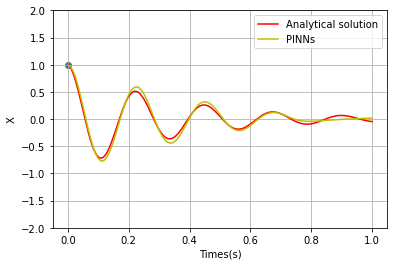

In [54]:
plt.plot(t,x,label="Analytical solution",c="r" )
#plt.plot(t1,x1[:1000],label="Delta t = 0.001", linestyle='--',c="b")
#plt.plot(t2,x2[:200],label="Delta t = 0.005",linestyle='--',c="g")
#plt.plot(t3,x3[:56],label="Delta t = 0.015",linestyle='--',c="y")
plt.plot(t_test, x_test, label="PINNs", c="y")
plt.scatter(t_data, x_data)
plt.xlabel("Times(s)")
plt.ylabel("X")
plt.grid(True)
plt.ylim(-2.0, 2.0)
plt.legend()
plt.show()

In [55]:
x_test_list = []
for i in PINNs.model_loc:
    x_test_list.append(i.predict(t_test))

4/4 [==============================] - 0s 1ms/step


0


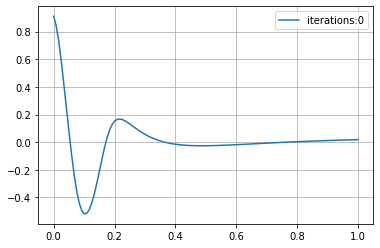

In [56]:
for i in range(0,len(x_test_list),10):
    plt.plot(t_test, x_test_list[i], label="iterations:{}".format(i))
    print(i)
    plt.legend()
    plt.grid(True)